In [1]:
import os
import sys
p = os.path.abspath('..')
if p not in sys.path:
    sys.path.append(p)

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt 
import tikzplotlib
import pickle, datetime, json, time
from pathlib import Path
from src.mc import MarkovChainLobModel
from src.lob import LOB
from src.mc_functions import load_data_mc, setup_model_spec_mc
from src.rnn import LobRNN
from src.evaluation import price_signature

In [2]:
seed = 111
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
plt.rcParams.update({'font.size': 20})

In [4]:
save_figs = True
timestamps = ["2022_05_27_16_05", "2022_05_27_16_06", "2022_05_27_16_07", "2022_05_27_16_08", "2022_05_27_16_09"]
num_runs = len(timestamps)

## Setup parameters etc

In [5]:
info = {}
info["num_runs"] = int(1e3)
info["volume"] = 5
info["timedelta"] = 10.
info["padding"] = (10, 10)
info["timefactor"] = 5
info["end_time"] = info["padding"][0] + info["padding"][1] + (info["timedelta"]*(info["volume"]-1))
info["ps_delta"] = np.array((0,5)).tolist()
info["timestamp"] = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
info["data_path"] =  os.path.join(p , "data/twap_simulations/" + "twap_" + info["timestamp"])

In [6]:
rnn_paths = [os.path.join(p, 'models/checkpoints/mc_lob_rnn_{}'.format(t)) for t in timestamps]
info["rnn_info_paths"] = [os.path.join(r,'model_info.txt') for r in rnn_paths]
info["rnn_checkpoint_paths"] = [os.path.join(r, 'lob_{}_lstm_predict_model.hdf5') for r in rnn_paths]

rnn_info = []
for r in info["rnn_info_paths"]:
    with open(r) as file:
        rnn_info.append(json.load(file))

## Get start LOB from training data

In [7]:
data, event_types, rnn_info = load_data_mc(rnn_info[0])
info["start_lob"] = os.path.join(p, 'data/mc_train.pkl')
ob_data = data["ob"][0]
start_len = rnn_info["seq_length"]
start_ind = np.random.choice(ob_data.shape[0]-start_len, info["num_runs"], replace=False)
start_dict = {}
start_dict["ob"] = [ob_data[i:i+start_len,...].astype(int) for i in start_ind]
for k, v in data.items():
    if k != "ob":
        start_dict[k] = [v[0][i:i+start_len] for i in start_ind]

## Function to simulate TWAPs

In [8]:
def simulate_twaps(twap_function, num_runs, volume, end_time, timefactor, start_dict, padding=(10,10)):
    num_times = int(end_time * timefactor) + 2
    twap_dict = {}
    twap_dict["num_tries"] = 0
    twap_dict["price"] = np.nan*np.zeros((num_runs,1))
    twap_dict["num_events"] = np.zeros((num_runs,1))
    twap_dict["num_mo"] = np.zeros((num_runs,1))
    twap_dict["num_mo_bid"] = np.zeros((num_runs,1))
    twap_dict["num_mo_ask"] = np.zeros((num_runs,1))
    twap_dict["num_lo_filled"] = np.zeros((num_runs,1))
    twap_dict["mid_vals"] = np.zeros((num_runs, num_times))
    twap_dict["ask_vals"] = np.zeros((num_runs, num_times))
    twap_dict["bid_vals"] = np.zeros((num_runs, num_times))
    twap_dict["time_vals"] = np.zeros((num_runs, num_times+1))

    initial_dict = {}
    for i in range(num_runs):
        if not i % 100:
            print('iteration: ', i)
        finished = False
        while not finished:
            twap_dict["num_tries"] += 1
            for k,v in start_dict.items():
                if k == "ob":
                    initial_dict[k] = v[i].copy().squeeze()
                else:
                    initial_dict[k] = v[i].copy()
            t0 = time.time()
            twap_tmp = twap_function(volume, end_time, timefactor, initial_dict, padding)
            t1 = time.time()
            print('time: ', t1-t0)
            finished = twap_tmp["finished"]
            if finished:
                for k,v in twap_tmp.items():
                    if k != "finished":
                        twap_dict[k][i,:] = v
    if not twap_dict["num_mo"].any():
        twap_dict["num_mo"] = twap_dict["num_mo_bid"] + twap_dict["num_mo_ask"]
    
    return twap_dict

## Simulate TWAPs using MC LOB model

In [ ]:
mc_dict = []
for i in range(num_runs):
    print('RUN: ', i)
    mc_model = MarkovChainLobModel(num_levels=start_dict["ob"][0].shape[-1]-1, ob_start=start_dict["ob"][0][-1,...].copy())
    def mc_twap(v, e, t, d, p): 
        d = d.copy()
        for k in d:
            d[k] = d[k][-1,...]
        return mc_model.run_twap(v,e,t,d,p)
    mc_dict.append(simulate_twaps(mc_twap, info["num_runs"], info["volume"], info["end_time"], info["timefactor"], start_dict, padding=info["padding"]))

In [10]:
for m in mc_dict:
    mc_start_mid = m["mid_vals"][:,0,np.newaxis]
    m["mid_vals"] = m["mid_vals"] - mc_start_mid
    m["bid_vals"] = m["bid_vals"] - mc_start_mid
    m["ask_vals"] = m["ask_vals"] - mc_start_mid
    m["price"] = m["price"] - info["volume"]*mc_start_mid

In [11]:
[m["num_tries"] for m in mc_dict]

[1000, 1000, 1000, 1000, 1000]

## Simulate TWAPs using RNN trained on MC model data

In [12]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
        
rnn_dict = []
        
for i in range(num_runs):
    print("RUN: ", i)
    args = Namespace(**rnn_info)

    # load training data
    data, event_types, args = load_data_mc(args)

    # set up model
    model_spec = setup_model_spec_mc(args)
    rnn = LobRNN(data, model_spec, event_types, integer_size=True, outside_volume = 1)

    model = rnn.setup_model(args, predict=True, device='/cpu:0')
    for k,v in model.items():
        v.load_weights(info["rnn_checkpoint_paths"][i].format(k))
        
    rnn_twap_function = lambda v, et, tf, x0, pad: rnn.run_twap(model, v, et, tf, x0, pad)
    rnn_dict.append(simulate_twaps(rnn_twap_function, info["num_runs"], info["volume"], info["end_time"], info["timefactor"], start_dict, padding=info["padding"]))

RUN:  0
event
model inputs: 
[<tf.Tensor 'ob_input:0' shape=(1, 1, 2, 11) dtype=float32>, <tf.Tensor 'ask_input:0' shape=(1, 1, 1) dtype=float32>, <tf.Tensor 'bid_input:0' shape=(1, 1, 1) dtype=float32>, <tf.Tensor 'event_input:0' shape=(1, 1, 1) dtype=float32>, <tf.Tensor 'level_input:0' shape=(1, 1, 1) dtype=float32>, <tf.Tensor 'size_input:0' shape=(1, 1, 1) dtype=float32>, <tf.Tensor 'time_input:0' shape=(1, 1, 1) dtype=float32>]
Tensor("concatenate/concat:0", shape=(1, 64), dtype=float32, device=/device:CPU:0)
model output:  Tensor("SelectV2_1:0", shape=(1, 6), dtype=float32, device=/device:CPU:0)
level
model inputs: 
[<tf.Tensor 'ob_input:0' shape=(1, 1, 2, 11) dtype=float32>, <tf.Tensor 'ask_input:0' shape=(1, 1, 1) dtype=float32>, <tf.Tensor 'bid_input:0' shape=(1, 1, 1) dtype=float32>, <tf.Tensor 'event_input:0' shape=(1, 1, 1) dtype=float32>, <tf.Tensor 'level_input:0' shape=(1, 1, 1) dtype=float32>, <tf.Tensor 'size_input:0' shape=(1, 1, 1) dtype=float32>, <tf.Tensor 'time_i

C:\Users\s1436ba\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


time:  4.433322429656982
time:  2.203453302383423
time:  2.950075387954712
time:  2.5472564697265625
time:  2.9399983882904053
time:  3.208469867706299
time:  3.3826138973236084
time:  3.2840096950531006
time:  3.2348592281341553
time:  2.5639262199401855
time:  2.1409449577331543
time:  3.454746723175049
time:  3.055816888809204
time:  2.812446355819702
time:  3.439171075820923
time:  3.233501434326172
time:  2.5202014446258545
time:  3.345364809036255
time:  2.812919855117798
time:  3.096179246902466
time:  3.314099073410034
time:  3.750561237335205
time:  2.9580862522125244
time:  2.859804153442383
time:  3.5612926483154297
time:  2.88430118560791
time:  3.0479977130889893
time:  3.1668450832366943
time:  2.9608991146087646
time:  2.8214988708496094
time:  3.079725980758667
time:  3.1410956382751465
time:  3.0877485275268555
time:  2.689008951187134
time:  2.628436803817749
time:  3.4785845279693604
time:  3.5161540508270264
time:  3.298490285873413
time:  2.7416388988494873
time:  

In [13]:
for r in rnn_dict:
    start_mid_rnn = r["mid_vals"][:,0,np.newaxis]
    r["mid_vals"] = r["mid_vals"] - start_mid_rnn
    r["bid_vals"] = r["bid_vals"] - start_mid_rnn
    r["ask_vals"] = r["ask_vals"] - start_mid_rnn
    r["price"] = r["price"] - info["volume"]*start_mid_rnn

In [14]:
[r["num_tries"] for r in rnn_dict]

[1000, 1000, 1000, 1000, 1000]

## Visualize results

In [15]:
mc_dict[0]["mid_vals"].shape

(1000, 302)

In [16]:
def plot_mean(ax, dict_list, key, label):
    vals = np.stack([np.mean(m[key], axis=0) for m in dict_list])
    mean_vals = np.mean(vals, axis=0)
    std_vals = np.std(vals, axis=0)
    tx = np.arange(dict_list[0][key].shape[1])/info["timefactor"]
    ax.errorbar(tx, mean_vals, yerr=std_vals, label=label, capsize=3, alpha=.75, fmt="--", errorevery=20)
    ax.fill_between(tx, mean_vals-std_vals, mean_vals+std_vals,alpha=0.25)
    return ax

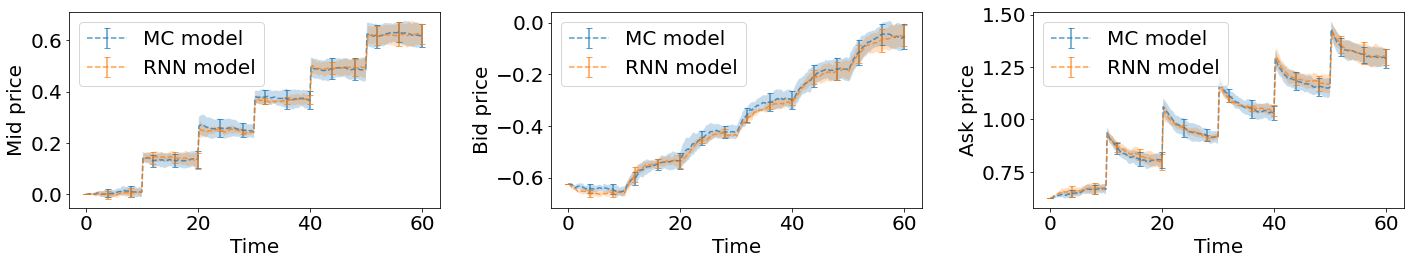

In [17]:
fig = plt.figure(figsize=[20,4])
ax = fig.add_subplot(1,3,1)
ax = plot_mean(ax, mc_dict, "mid_vals", "MC model")
ax = plot_mean(ax, rnn_dict, "mid_vals", "RNN model")
#ax.set_title("Mid price when buying 1 unit every 10 seconds")
ax.legend(loc="upper left");
ax.set_xlabel("Time")
ax.set_ylabel("Mid price");

ax = fig.add_subplot(1,3,2)
ax = plot_mean(ax, mc_dict, "bid_vals", "MC model")
ax = plot_mean(ax, rnn_dict, "bid_vals", "RNN model")

#ax.set_title("Bid price when buying 1 unit every 10 seconds")
ax.legend(loc="upper left");
ax.set_xlabel("Time")
ax.set_ylabel("Bid price");

ax = fig.add_subplot(1,3,3)
ax = plot_mean(ax, mc_dict, "ask_vals", "MC model")
ax = plot_mean(ax, rnn_dict, "ask_vals", "RNN model")

#ax.set_title("Ask price when buying 1 unit every 10 seconds")
ax.legend(loc="upper left");
ax.set_xlabel("Time")
ax.set_ylabel("Ask price");
plt.tight_layout()
plt.subplots_adjust(wspace=.3, hspace=0)
if save_figs:
    plt.savefig("images/twap_prices.png")
    tikzplotlib.save("images/twap_prices.tex", encoding='utf-8')

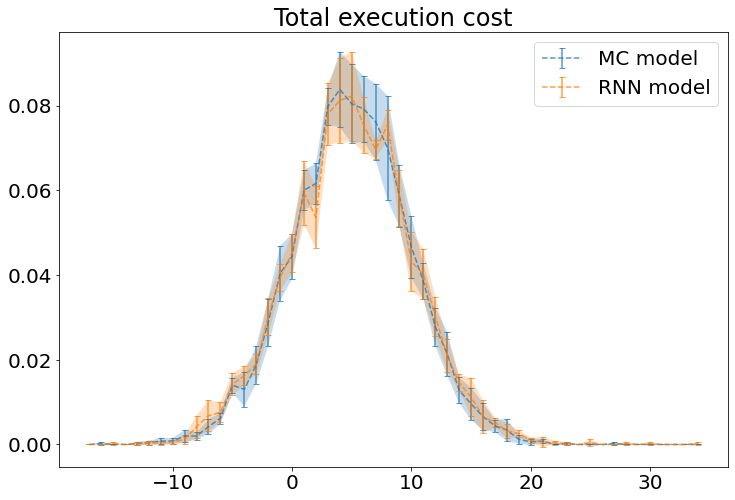

In [18]:
min_mc_price = np.min([np.min(m["price"]) for m in mc_dict])
min_rnn_price = np.min([np.min(m["price"]) for m in rnn_dict])
min_price = np.min([min_mc_price, min_rnn_price])
max_mc_price = np.max([np.max(m["price"]) for m in mc_dict])
max_rnn_price = np.max([np.max(m["price"]) for m in rnn_dict])
max_price = np.max([max_mc_price, max_rnn_price])
bins = np.arange(min_price-1, max_price+2)
mc_freqs = np.stack([np.histogram(m["price"], bins=bins, density=True)[0] for m in mc_dict])
rnn_freqs = np.stack([np.histogram(m["price"], bins=bins, density=True)[0] for m in rnn_dict])

fig1 = plt.figure(figsize=[12, 8])
plt.errorbar((bins[1:] + bins[:-1])/2, np.mean(mc_freqs, axis=0), yerr=np.std(mc_freqs, axis=0), alpha=.75, fmt="--", capsize=3, label="MC model")
plt.fill_between((bins[1:] + bins[:-1])/2, np.mean(mc_freqs, axis=0)-np.std(mc_freqs, axis=0), np.mean(mc_freqs, axis=0)+np.std(mc_freqs, axis=0), alpha=.25)
plt.errorbar((bins[1:] + bins[:-1])/2, np.mean(rnn_freqs, axis=0), yerr=np.std(rnn_freqs, axis=0), alpha=.75, fmt="--", capsize=3, label="RNN model")
plt.fill_between((bins[1:] + bins[:-1])/2, np.mean(rnn_freqs, axis=0)-np.std(rnn_freqs, axis=0), np.mean(rnn_freqs, axis=0)+np.std(rnn_freqs, axis=0), alpha=0.25)
plt.title("Total execution cost")
plt.legend();

if save_figs:
    plt.savefig("images/twap_total_price.png")
    tikzplotlib.save("images/twap_total_price.tex", encoding='utf-8')

## Save results

In [19]:
dict_to_save = {"info": info, "rnn_info": rnn_info, "mc_dict": mc_dict, "rnn_dict": rnn_dict}
pickle.dump(dict_to_save, open(info["data_path"] + ".pkl", "wb"))

with open(info["data_path"] + '_info.txt', 'w') as file:
     file.write(json.dumps(info)) 